# Wasserstein Empirical Distribution

Short recap of previous work: 
1. For each of two energy levels ($E=12\,J$ and $E=120\,J$), we have calculated 1000 paths (of length 100k) for the double pendulum (recording all $\theta_1$, $\theta_2$, $\omega_1$, $\omega_2$). 
2. We saw that for $E=12\,J$ all observables exhibit ergodic behavior whereas for $E=120\,J$, $\omega_1$ and $\omega_2$ exhibit non-ergodic behavior (depending on the initial condition, some paths converge to one shape, whereas others to another, and some to a combination of both)
3. This allows us to study how the W-1 distance between the trajectory distribution and the ensemble distribution is distributed for both ergodic- and non-ergodic-looking paths. 

Note: `paths 1` refers to the paths of energy level $E=12\,J$ and `paths 2` refers to the aths of energy level $E=120\,J$. 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df1 = pd.read_csv('AVMs2/paths1_results.csv')
df2 = pd.read_csv('AVMs2/paths2_results.csv')

# Define labels for the plots
labels = {
    'W1_1': r'$\theta_1$',
    'W1_2': r'$\omega_1$',
    'W1_3': r'$\theta_2$',
    'W1_4': r'$\omega_2$'
}

# Set the visual style
sns.set_theme(style="whitegrid")

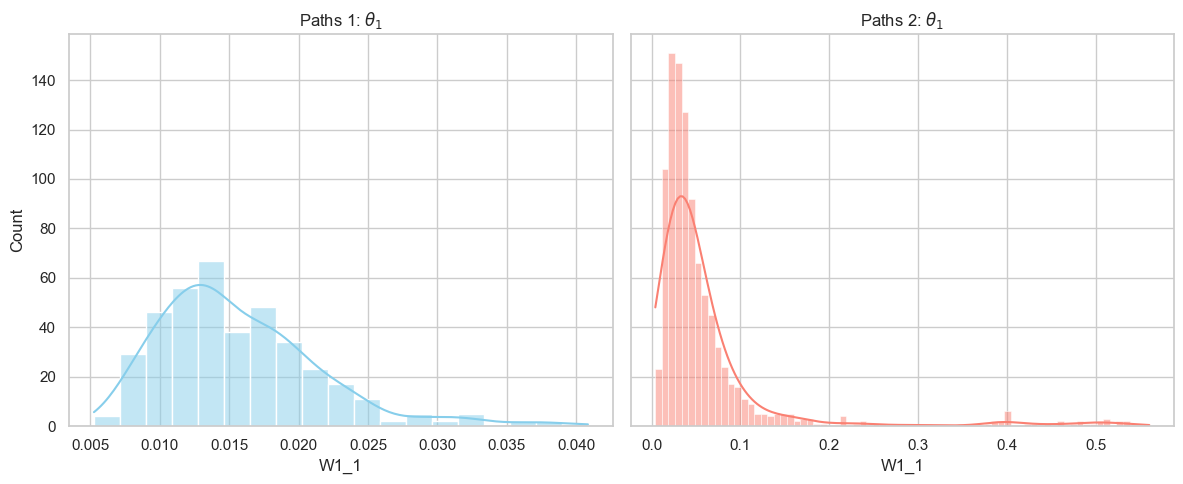

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(df1['W1_1'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Paths 1: {labels["W1_1"]}')

sns.histplot(df2['W1_1'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Paths 2: {labels["W1_1"]}')

plt.tight_layout()
plt.show()

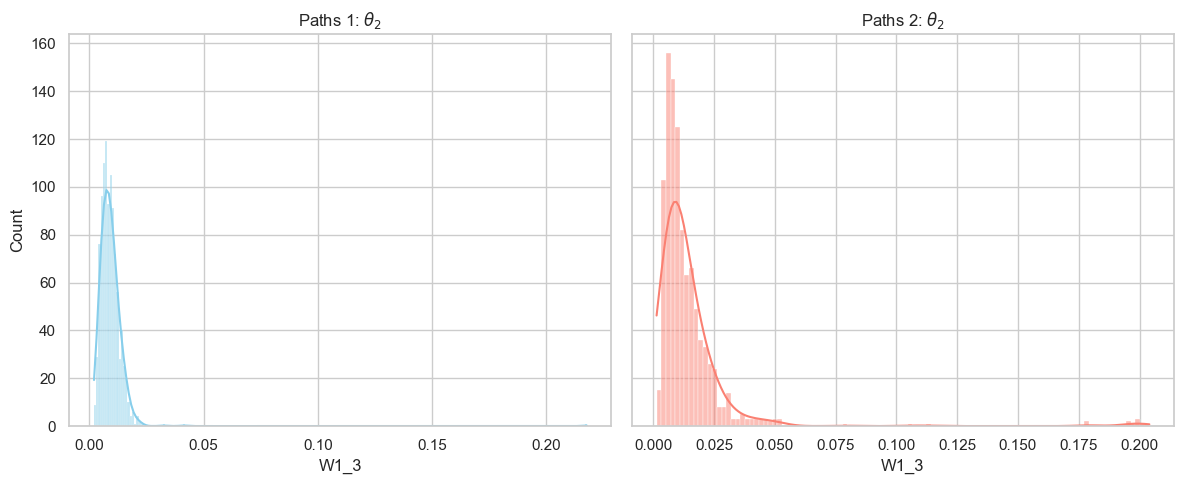

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(df1['W1_3'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Paths 1: {labels["W1_3"]}')

sns.histplot(df2['W1_3'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Paths 2: {labels["W1_3"]}')

plt.tight_layout()
plt.show()

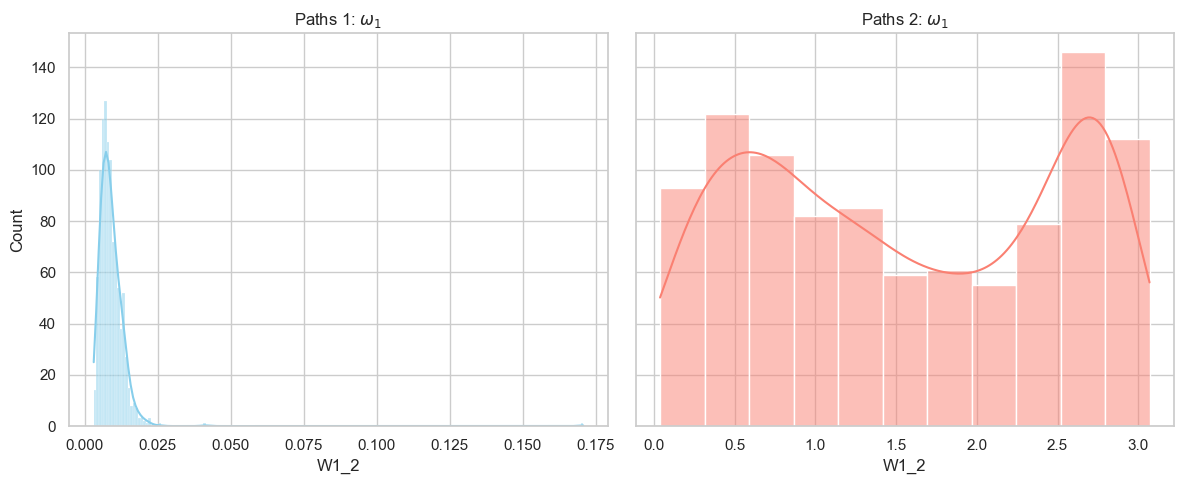

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(df1['W1_2'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Paths 1: {labels["W1_2"]}')

sns.histplot(df2['W1_2'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Paths 2: {labels["W1_2"]}')

plt.tight_layout()
plt.show()

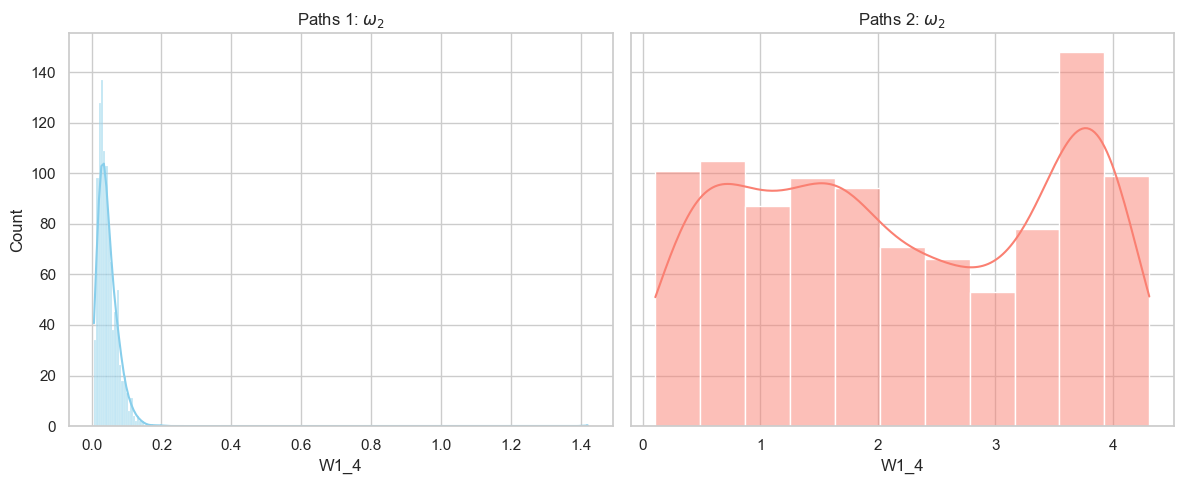

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(df1['W1_4'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Paths 1: {labels["W1_4"]}')

sns.histplot(df2['W1_4'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title(f'Paths 2: {labels["W1_4"]}')

plt.tight_layout()
plt.show()

## Kolmogorov-Smirnoff Test

Simulating theoretical reference distribution...

=== Kolmogorov-Smirnov Test Results ===
Testing H0: Empirical data follows the area under a Brownian Bridge distribution.


,Dataset,Variable,K-S Stat,P-Value,Conclusion
0,Paths 1,$\omega_2$,0.1498,7.5597e-20,Reject H0 (Not BB)
1,Paths 2,$\omega_2$,0.2089,2.1655e-38,Reject H0 (Not BB)


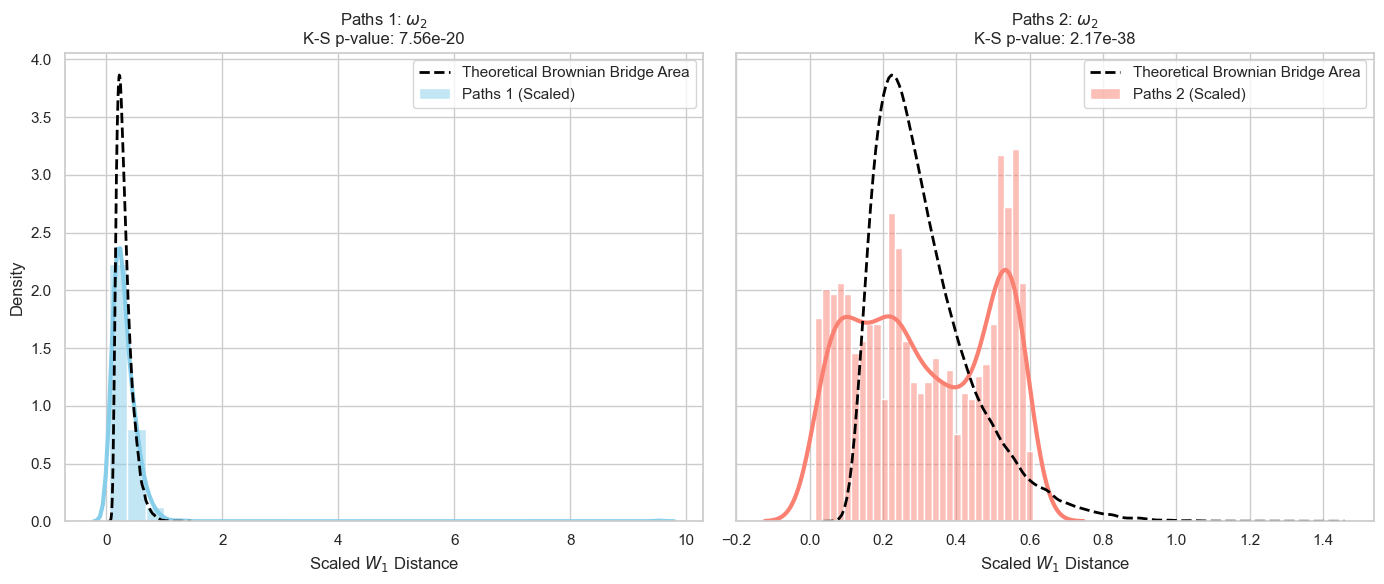

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 1. Generate Theoretical Distribution (Reference) ---
def simulate_brownian_bridge_area(n_samples=100000, n_steps=1000):
    """Generates samples of Z = int_0^1 |B_bridge(t)| dt"""
    dt = 1.0 / n_steps
    # Brownian motion: Cumulative sum of Gaussian increments
    dW = np.sqrt(dt) * np.random.randn(n_samples, n_steps)
    W = np.cumsum(dW, axis=1)
    W = np.hstack([np.zeros((n_samples, 1)), W]) # Start at 0
    
    # Brownian Bridge transform: B(t) = W(t) - t * W(1)
    t = np.linspace(0, 1, n_steps + 1)
    B = W - t * W[:, -1][:, np.newaxis]
    
    # Integrate absolute value (Trapezoidal rule)
    return np.trapz(np.abs(B), dx=dt, axis=1)

print("Simulating theoretical reference distribution...")
Z_theoretical = simulate_brownian_bridge_area()
theoretical_mean = np.mean(Z_theoretical) # approx 0.3133

# --- 2. Perform K-S Test & Plot ---
# We focus on W1_4 (omega_2) as requested
target_col = 'W1_4'
datasets = [
    ("Paths 1", df1[target_col].dropna(), 'skyblue'),
    ("Paths 2", df2[target_col].dropna(), 'salmon')
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ks_results = []

for i, (label, data, color) in enumerate(datasets):
    # Rescale empirical data to match the theoretical mean.
    # This removes the unknown sigma/sqrt(T) factor to test the SHAPE only.
    scale_factor = theoretical_mean / data.mean()
    data_scaled = data * scale_factor
    
    # Kolmogorov-Smirnov Test (2-sample)
    # Null Hypothesis: The two samples are drawn from the same distribution
    ks_stat, p_val = stats.ks_2samp(data_scaled, Z_theoretical)
    
    ks_results.append({
        "Dataset": label,
        "Variable": labels[target_col],
        "K-S Stat": f"{ks_stat:.4f}",
        "P-Value": f"{p_val:.4e}",
        "Conclusion": "Reject H0 (Not BB)" if p_val < 0.05 else "Cannot Reject H0 (Consistent with BB)"
    })
    
    # Plot
    ax = axes[i]
    sns.histplot(data_scaled, stat="density", bins=30, color=color, alpha=0.5, label=f'{label} (Scaled)', ax=ax)
    sns.kdeplot(data_scaled, color=color, linewidth=3, ax=ax)
    
    # Overlay Theoretical Curve
    sns.kdeplot(Z_theoretical, color='black', linestyle='--', linewidth=2, label='Theoretical Brownian Bridge Area', ax=ax)
    
    ax.set_title(f"{label}: {labels[target_col]}\nK-S p-value: {p_val:.2e}")
    ax.set_xlabel(r"Scaled $W_1$ Distance")
    ax.legend()

# --- 3. Output Results ---
print("\n=== Kolmogorov-Smirnov Test Results ===")
print(f"Testing H0: Empirical data follows the area under a Brownian Bridge distribution.")
results_df = pd.DataFrame(ks_results)
display(results_df)

plt.tight_layout()
plt.show()

Simulating theoretical reference distribution...

=== Chi-Squared Goodness of Fit Results ===
Testing H0: Empirical data follows the area under a Brownian Bridge distribution.


,Dataset,Variable,Chi2 Stat,P-Value,Conclusion
0,Paths 1,$\omega_2$,20.2221,6.8950e-06,Reject H0
1,Paths 2,$\omega_2$,4532.9073,0.0000e+00,Reject H0


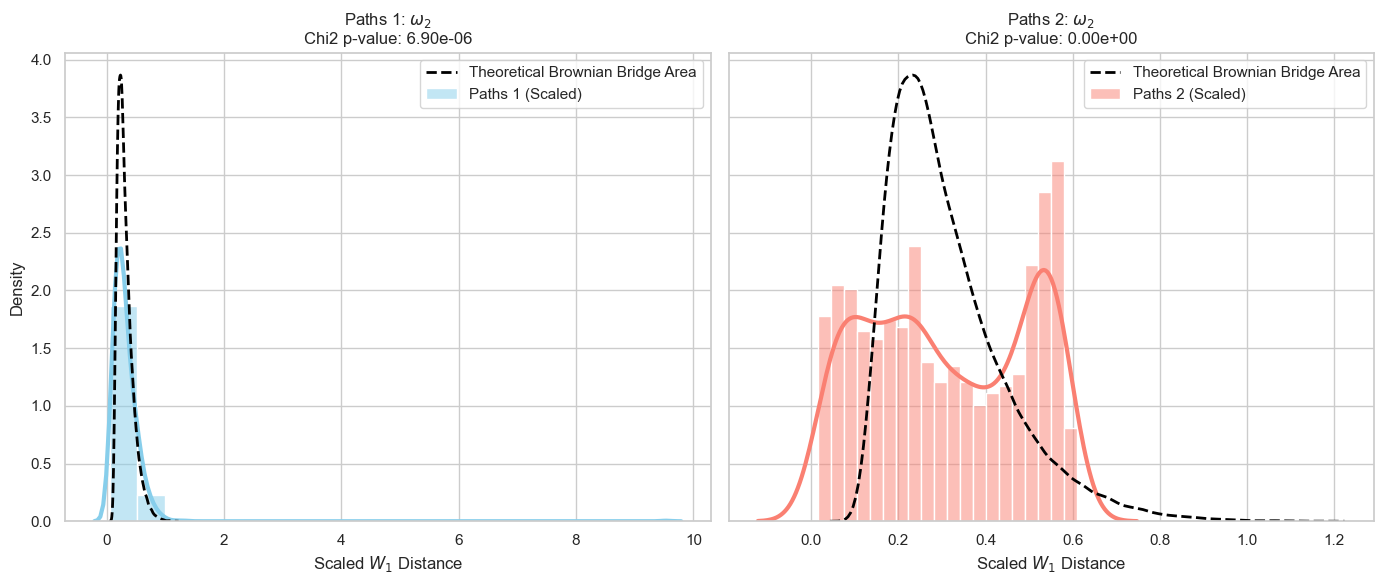

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 1. Generate Theoretical Distribution (Reference) ---
def simulate_brownian_bridge_area(n_samples=100000, n_steps=1000):
    """Generates samples of Z = int_0^1 |B_bridge(t)| dt"""
    dt = 1.0 / n_steps
    # Brownian motion: Cumulative sum of Gaussian increments
    dW = np.sqrt(dt) * np.random.randn(n_samples, n_steps)
    W = np.cumsum(dW, axis=1)
    W = np.hstack([np.zeros((n_samples, 1)), W]) # Start at 0
    
    # Brownian Bridge transform: B(t) = W(t) - t * W(1)
    t = np.linspace(0, 1, n_steps + 1)
    B = W - t * W[:, -1][:, np.newaxis]
    
    # Integrate absolute value (Trapezoidal rule)
    return np.trapz(np.abs(B), dx=dt, axis=1)

print("Simulating theoretical reference distribution...")
Z_theoretical = simulate_brownian_bridge_area()
theoretical_mean = np.mean(Z_theoretical) # approx 0.3133

# --- 2. Perform Chi-Squared Test & Plot ---
# We focus on W1_1 (theta_1) as requested
target_col = 'W1_4'
datasets = [
    ("Paths 1", df1[target_col].dropna(), 'skyblue'),
    ("Paths 2", df2[target_col].dropna(), 'salmon')
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
chi2_results = []

for i, (label, data, color) in enumerate(datasets):
    scale_factor = theoretical_mean / data.mean()
    data_scaled = data * scale_factor
    
    # 1. Create Bins
    observed_counts, bin_edges = np.histogram(data_scaled, bins=20) # Reduced to 20 for safety
    
    # 2. Calculate Expected Frequencies
    expected_probs = []
    for j in range(len(bin_edges)-1):
        lower, upper = bin_edges[j], bin_edges[j+1]
        count_in_bin = np.sum((Z_theoretical >= lower) & (Z_theoretical < upper))
        expected_probs.append(count_in_bin)
    
    expected_probs = np.array(expected_probs) / len(Z_theoretical)
    expected_counts = expected_probs * len(data_scaled)
    
    # --- FIX: Filter out bins with 0 expected counts ---
    # We create a mask for valid bins where Expected > 0 (standard practice is often > 5)
    valid_bins_mask = expected_counts > 0 
    
    # Apply mask to both arrays
    f_obs_safe = observed_counts[valid_bins_mask]
    f_exp_safe = expected_counts[valid_bins_mask]
    
    # Re-normalize expected counts to match observed sum exactly
    # (Crucial step after filtering, otherwise sums won't match)
    if np.sum(f_exp_safe) > 0:
        f_exp_safe = f_exp_safe * (np.sum(f_obs_safe) / np.sum(f_exp_safe))
    
    # 3. Run Test on Safe Data
    if len(f_obs_safe) > 1:
        chi2_stat, p_val = stats.chisquare(f_obs=f_obs_safe, f_exp=f_exp_safe, ddof=1)
    else:
        chi2_stat, p_val = np.nan, np.nan # Not enough valid bins
        
    chi2_results.append({
        "Dataset": label,
        "Variable": labels[target_col],
        "Chi2 Stat": f"{chi2_stat:.4f}",
        "P-Value": f"{p_val:.4e}",
        "Conclusion": "Reject H0" if p_val < 0.05 else "Cannot Reject H0"
    })
    
    # Plot
    ax = axes[i]
    sns.histplot(data_scaled, stat="density", bins=20, color=color, alpha=0.5, label=f'{label} (Scaled)', ax=ax)
    sns.kdeplot(data_scaled, color=color, linewidth=3, ax=ax)
    
    # Overlay Theoretical Curve
    sns.kdeplot(Z_theoretical, color='black', linestyle='--', linewidth=2, label='Theoretical Brownian Bridge Area', ax=ax)
    
    ax.set_title(f"{label}: {labels[target_col]}\nChi2 p-value: {p_val:.2e}")
    ax.set_xlabel(r"Scaled $W_1$ Distance")
    ax.legend()

# --- 3. Output Results ---
print("\n=== Chi-Squared Goodness of Fit Results ===")
print(f"Testing H0: Empirical data follows the area under a Brownian Bridge distribution.")
results_df = pd.DataFrame(chi2_results)
display(results_df)

plt.tight_layout()
plt.show()